In [2]:
pip install datasets transformers  --quiet


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
import ast
from transformers import BertTokenizer
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

In [4]:
ds1 = load_dataset("sjsurbhi/english-to-french-translation")#)#)                #loaded dataset from HuggingFace "sethjsa/wmt_en_fr_parallel")#
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', use_fast=True)   #loaded tokenizer from Huggingface
#tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") 

In [3]:
ds= load_dataset("sethjsa/wmt_en_fr_parallel")#)                #loaded dataset from HuggingFace "sethjsa/wmt_en_fr_parallel")#
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', use_fast=True) 

In [40]:
def clean_wmt_row(data, block_size=32):
    try:
        # Access the keys directly from the row
        src_text = data['en'].strip()
        src_tgt = data['fr'].strip()

        # encoding the Dataset into tokens
        src_ids = tokenizer.encode(src_text, add_special_tokens =True)
        tgt_ids = tokenizer.encode(src_tgt, add_special_tokens =True)

        return {
            'src_ids': src_ids,
            'tgt_ids': tgt_ids,
            'src_len': len(src_ids),
            'tgt_len': len(tgt_ids),
            'keep': len(src_ids) <= block_size and len(tgt_ids) <= block_size
        }
    except Exception:
        # If it fails, we must mark it as False so we can filter it out
        return {'src_ids': [], 'tgt_ids': [], 'src_len': 0, 'tgt_len': 0,'keep': True}

In [5]:
## assigning the parameters to variables
@dataclass
class TransformerConfig():
    batch_size:int = 2048      ## number of independent sequence to process in parallel
    #max_iter:int = 1      ##100k #epoches
    block_size: int = 512     #the maximum context length of the prediction
    #eval_interval: int =50
    #eval_iter:int = 2         #epoches before evaluation
    n_embd: int= 512     #512  #1024       # Dimensions dmodel
    n_head:int = 8     #18       # number of head in the multihead attention mechanism sub-head of the Transformer layer
    n_layer:int= 6
    dropout: float= 0.1
    head_size: int = n_embd//n_head    #dimension of key and value dk==dv == dmodel/n_head
    vocab_size: int = tokenizer.vocab_size

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1337)

In [6]:
import numpy as np
import random

class WMTBatchSampler:
    def __init__(self, dataset, max_tokens_per_batch=128, shuffle=True):
        self.max_tokens = max_tokens_per_batch
        self.shuffle = shuffle

        # Load lengths into RAM once (VERY FAST)
        self.src_lens = np.array(dataset['src_len'])
        self.tgt_lens = np.array(dataset['tgt_len'])
        self.item_lens = np.maximum(self.src_lens, self.tgt_lens)

        # Initial sort by length
        self.indices = np.argsort(self.item_lens)
        self._batches = self._build_batches()

    def _build_batches(self):
        batches = []
        current_batch = []
        max_len = 0

        for idx in self.indices:
            item_len = self.item_lens[idx]
            temp_max_len = max(max_len, item_len)

            if (len(current_batch) + 1) * temp_max_len <= self.max_tokens:
                current_batch.append(idx)
                max_len = temp_max_len
            else:
                batches.append(current_batch)
                current_batch = [idx]
                max_len = item_len
                
        if current_batch:
            batches.append(current_batch)
        return batches

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self._batches)
        for batch in self._batches:
            yield batch

    def __len__(self):
        return len(self._batches)

In [7]:
def collate_fn(batch):
    # batch is now a list of dictionaries from the Dataset
    src = [torch.tensor(item['src_ids'], dtype=torch.long) for item in batch]
    tgt = [torch.tensor(item['tgt_ids'], dtype=torch.long) for item in batch]

    src_padded = torch.nn.utils.rnn.pad_sequence(src, batch_first=True, padding_value=0)
    tgt_padded = torch.nn.utils.rnn.pad_sequence(tgt, batch_first=True, padding_value=0)

    return src_padded, tgt_padded

In [8]:
#===================================THE TRANSFORMER MODEL ARCHITECTURE ====================================
# implementing Self-Attention head
class SelfAttentionHead(nn.Module):
    def __init__(self, config,):# masked=False):
        super().__init__()
        self.config=config
        self.key = nn.Linear(config.n_embd, config.head_size, bias=False)             ##head_size is the dimension of the key (dk)
        self.query = nn.Linear(config.n_embd, config.head_size, bias =False)          ##head_size is the dimension of the query (dq)
        self.value = nn.Linear(config.n_embd, config.head_size, bias = False)         ##head_size is the dimension of the value (dv)

        self.dropout = nn.Dropout(config.dropout)

    def forward(self,x, context =None):
        """
        x: main input data
        context: y (target dataset)

        """
        B,T,C = x.shape #batch, timestamp, dimension
        dk = self.config.head_size

        # computing the attention score
        kv_input = context if context != None else x
        q = self.query(x) #B,T,head_size
        k = self.key(kv_input)
        v = self.value(kv_input)

        wei = q @ k.transpose(-2,-1) * dk**-0.5       #(B,T,head_size) @ (B,head_size,T) --> (B,T,T)
        wei_norm = F.softmax(wei,dim=-1)
        wei_norm = self.dropout(wei_norm)

        ## perform the weighted aggregation of the value
        #out = F.scaled_dot_product_attention(q,k,v, dropout_p=self.config.dropout, is_causal = False) #flash attention
        out = wei_norm @ v

        return out

In [9]:
class MaskedSelfAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.key = nn.Linear(config.n_embd, config.head_size, bias=False)             ##head_size is the dimension of the key (dk)
        self.query = nn.Linear(config.n_embd, config.head_size, bias =False)          ##head_size is the dimension of the query (dq)
        self.value = nn.Linear(config.n_embd, config.head_size, bias = False)         ##head_size is the dimension of the value (dv)

        self.register_buffer('tril', torch.tril(torch.ones(config.block_size, config.block_size)))

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        B,T,C = x.shape
        dk = self.config.head_size

        k = self.key(x)       #key from the encoder output
        q = self.query(x)     #query from the decoder input
        v = self.value(x)     #B,T,16    #value from the encoder output

        wei = q @ k.transpose(-2,-1) * dk**-0.5                      #(B,T,head_size) @ (B,head_size,T) --> (B,T,T)

        wei_masked = wei.masked_fill(self.tril[:T,:T]==0, float('-inf'))
        wei_norm = F.softmax(wei_masked, dim=-1)                           #normalized

        #out = F.scaled_dot_product_attention(q,k,v, dropout_p=self.config.dropout, is_causal = True) #flash attention
        wei_norm = self.dropout(wei_norm)

        ## perform the weighted aggregation of the value
        out = wei_norm @ v

        return out

In [10]:
## multihead attention
class MultiHeadAttention(nn.Module):
    def __init__(self, config, masked = False):
        super().__init__()
        self.masked = masked

        if masked is True:
            self.dec_heads = nn.ModuleList([MaskedSelfAttentionHead(config) for _ in range(config.n_head)])
        else:
            self.enc_heads = nn.ModuleList([SelfAttentionHead(config) for _ in range(config.n_head)])

        self.proj = nn.Linear(config.n_embd, config.n_embd)   #linear
        self.dropout= nn.Dropout(config.dropout)

    def forward(self, x, enc_out=None):
        if enc_out is not None:
            # cross attn head
            assert self.masked != True, "This should be a cross_attention head and should not be masked"
            out = torch.cat([h(x, enc_out) for h in self.enc_heads], dim = -1) #concatinating the output of the corss_attn heads
            out = self.dropout(self.proj(out))

        #decoder attn head
        elif enc_out is None and self.masked ==True:
            out = torch.cat([h(x) for h in self.dec_heads], dim = -1) #concatinating the output of masked attention heads in the decoder
            out = self.dropout(self.proj(out))

        else:
            # encoder attn head
            assert enc_out is None and self.masked!=True
            out = torch.cat([h(x, enc_out) for h in self.enc_heads], dim = -1) #concatinating the output of enc attn heads
            out = self.dropout(self.proj(out))

        return out

In [11]:
class FeedForward(nn.Module):
    """a simple linear layer followed by non linearity"""

    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4*config.n_embd),
            nn.ReLU(),
            nn.Linear(4*config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        )

    def forward(self, x):
        return self.net(x)

In [12]:
class Block(nn.Module):
    """
    Communication followed by Computation
    """
    def __init__(self, config, is_decoder = False):
        super().__init__()
        self.decoder =is_decoder
        if is_decoder:
            self.msk_attn = MultiHeadAttention(config, masked=True)     ## masked_attention head
            self.cross_attn = MultiHeadAttention(config)                ## cross_attention head
            self.ffwd = FeedForward(config)
            self.ln1 = nn.LayerNorm(config.n_embd)
            self.ln2 = nn.LayerNorm(config.n_embd)
            self.ln3 = nn.LayerNorm(config.n_embd)

        else:
            self.s_attn = MultiHeadAttention(config)                    ## self_attention head
            self.ffwd = FeedForward(config)
            self.ln1 = nn.LayerNorm(config.n_embd)
            self.ln2 = nn.LayerNorm(config.n_embd)

    def forward(self, x, enc_out=None):
        if enc_out !=None:
            #decoder block
            assert self.decoder is True, f"This is not a decoder block, accepts only one parameter"
            x= self.ln1(x + self.msk_attn(x))
            x = self.ln2(x + self.cross_attn(x, enc_out))
            x= self.ln3(x+ self.ffwd(x))

        else:
            #encoder block
            x= self.ln1(x + self.s_attn(x))
            x = self.ln2(x+self.ffwd(x))

        return x

In [ ]:
##creating out model with torch
class TransformerLanguageModel(nn.Module):
    def __init__(self, config):
        super().__init__()

        # The input embedding layer
        self.config=config
        self.tok_embedding_table = nn.Embedding(config.vocab_size, config.n_embd) ## embedding 
        self.input_position_table = nn.Embedding(config.block_size, config.n_embd) ##input positional encoding

        # The output embedding layer
        self.output_position_table = nn.Embedding(config.block_size, config.n_embd) ## output positional encoding

        # The encoder and decoder blocks
        self.encoder_blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        self.decoder_blocks = nn.ModuleList([Block(config, is_decoder=True) for _ in range(config.n_layer)])

        # The Linear model
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size)
        self.lm_head.weight = self.tok_embedding_table.weight     #tying the weight

    def forward(self, idx_input, idx_output, target=None):
        Bx,Tx = idx_input.shape
        By, Ty = idx_output.shape

        input_token_embd = self.tok_embedding_table(idx_input) #(B,T,C)
        input_pos_embd = self.input_position_table(torch.arange(Tx, device =device)) #(T,C)

        output_token_embd = self.tok_embedding_table(idx_output)
        output_pos_embd = self.output_position_table(torch.arange(Ty, device=device))

        x = input_token_embd + input_pos_embd #(B,T,C)
        enc_out = self.encoder_blocks(x)              # encoder block output

        y = output_token_embd + output_pos_embd #(B,T,C)
        for decoder in self.decoder_blocks:
            y = decoder(x=y, enc_out=enc_out)   # decoder block output

        ## applying the linear model
        logits= self.lm_head(y) ## (B,T, Vocab_size)

        if target == None:
            loss = None

        else:
            B,T,C = logits.shape
            logits = logits.reshape(B*T, C)
            target = target.reshape(B*T)
            loss = F.cross_entropy(logits, target, label_smoothing=0.1, ignore_index=tokenizer.pad_token_id)

        return logits, loss

    @torch.no_grad()
    def generate(self, src, max_new_tokens, sos_token_id=1, eos_token_id=2):
        """
        src: [Batch, Src_Seq_Len] (The English sentence)
        max_new_tokens: How many French words to generate
        """
        device = src.device
        B,T = src.shape

        #Encode the source
        input_token_embd = self.tok_embedding_table(src)
        input_pos_embd = self.input_position_table(torch.arange(T, device=device))
        x = input_token_embd + input_pos_embd
        enc_output = self.encoder_blocks(x)

        # 2. Initialize the decoder input with the [SOS] token
        idx = torch.full((B, 1), sos_token_id, dtype=torch.long, device=device)

        for _ in range(max_new_tokens):
            # Only take the last 'block_size' tokens if the sequence gets too long
            idx_cond = idx[:, -self.config.block_size:]

            # Get embeddings for current decoder input
            output_token_embd = self.tok_embedding_table(idx_cond)
            output_pos_embd = self.output_position_table(torch.arange(idx_cond.shape[1], device=device))
            y_process = output_token_embd + output_pos_embd

            # Pass through decoder blocks
            decoder_input = y_process
            for decoder_block in self.decoder_blocks:
                decoder_input = decoder_block(x=decoder_input, enc_out=enc_output)
            decoder_output= decoder_input

            # Apply linear head to get logits
            logits = self.lm_head(decoder_output)

            logits = logits[:, -1, :] # [Batch, Vocab_Size] Focus on the last time step

            idx_next = torch.argmax(logits, dim=-1, keepdim=True) # [Batch, 1]
            idx = torch.cat((idx, idx_next), dim=1) #Append to the sequence

            if (idx_next == eos_token_id).all():
                break

        # Decode the generated dataset
        gen_words = tokenizer.batch_decode(idx, add_special_tokens=True) #input tokens

        return gen_words

In [ ]:
def clean_wmt_row(row, block_size=32):
    try:
        src_text = row['prompt'][0]['content'].replace('Translate this into French:', '').strip()
        tgt_text = row['completion'][0]['content'].strip()

        # Encoding the source and target text into token ids
        src_ids = tokenizer.encode(src_text, add_special_tokens=True)
        tgt_ids = tokenizer.encode(tgt_text, add_special_tokens=True)

        return {
            'src_ids': src_ids,
            'tgt_ids': tgt_ids,
            'src_len': len(src_ids),
            'tgt_len': len(tgt_ids),
            'keep': len(src_ids) <= block_size and len(tgt_ids) <= block_size
        }
    
    except Exception as e:
        # Mark as keep=False so we can filter out corrupted rows
        return {'src_ids': [], 'tgt_ids': [], 'src_len': 0, 'tgt_len': 0, 'keep': False}

In [15]:
split_ds = ds1['train'].train_test_split(test_size=0.2, seed=42)

train_d = split_ds['train']
val_d = split_ds['test']

train_data = train_d.map(clean_wmt_row, fn_kwargs={"block_size":128})
# Filter out rows that are too long or malformed
tds = train_data.filter(lambda x: x['keep'])

val_data = val_d.map(clean_wmt_row, fn_kwargs={"block_size":128})
vlds = val_data.filter(lambda x: x['keep'])

In [16]:
print(f"Max allowed: 128")
print(f"Actual length: {len(tds)}")

# Look at the first 5 rows
for i in range(15):
    s_len = len(tds[i]['src_ids'])
    t_len = len(tds[i]['tgt_ids'])
    print(f"Row {i} - English Tokens: {s_len}, French Tokens: {t_len}")

Max allowed: 128
Actual length: 791361
Row 0 - English Tokens: 12, French Tokens: 12
Row 1 - English Tokens: 13, French Tokens: 11
Row 2 - English Tokens: 14, French Tokens: 15
Row 3 - English Tokens: 8, French Tokens: 13
Row 4 - English Tokens: 6, French Tokens: 23
Row 5 - English Tokens: 15, French Tokens: 18
Row 6 - English Tokens: 38, French Tokens: 55
Row 7 - English Tokens: 6, French Tokens: 5
Row 8 - English Tokens: 21, French Tokens: 23
Row 9 - English Tokens: 17, French Tokens: 28
Row 10 - English Tokens: 28, French Tokens: 29
Row 11 - English Tokens: 12, French Tokens: 16
Row 12 - English Tokens: 63, French Tokens: 74
Row 13 - English Tokens: 54, French Tokens: 94
Row 14 - English Tokens: 8, French Tokens: 11


In [ ]:
## saving the prepared dataset
tds.save_to_disk('/prepared_tr_dataset')
vlds.save_to_disk('/prepared_val_dataset')

In [17]:
# Batch Dataset
tr_sampler = WMTBatchSampler(tds, max_tokens_per_batch=2048)#, max_tokens=config.batch_size * config.block_size)
val_sampler = WMTBatchSampler(vlds, max_tokens_per_batch=2048)#, max_tokens=config.batch_size * config.block_size)

#Load to DataLoader
train_loader = DataLoader(tds, batch_sampler=tr_sampler, collate_fn=collate_fn, num_workers=8)
val_loader = DataLoader(vlds, batch_sampler=val_sampler, collate_fn=collate_fn, num_workers=4)

In [18]:
pip install sacrebleu --quiet


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
## Evaluating BLEU Score
import sacrebleu

def calculate_bleu(model, dataloader, tokenizer, device, max_new_tokens=128):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        # We only evaluate a subset (e.g., 10 batches) to keep training fast
        for i, (src, tgt) in enumerate(dataloader):
            if i > max_new_tokens: break

            src = src.to(device)
            
            # model.generate now returns decoded strings, not token IDs
            decoded_preds = model.generate(src, max_new_tokens=max_new_tokens)
            decoded_tgts = tokenizer.batch_decode(tgt, skip_special_tokens=True)

            all_preds.extend(decoded_preds)
            all_targets.extend(decoded_tgts)

    bleu = sacrebleu.corpus_bleu(all_preds, [[ref] for ref in all_targets])
    return bleu.score

In [20]:
def estimate_loss(model, loader, eval_iters=20):
    """ Helper to get a stable loss estimate without running the whole dataset """
    model.eval()
    losses = torch.zeros(eval_iters)

    # Use a temporary iterator to grab a few batches
    data_iter = iter(loader)

    with torch.no_grad():
        for k in range(eval_iters):
            try:
                X, Y = next(data_iter)
            except StopIteration: # If we hit the end, restart
                data_iter = iter(loader)
                X, Y = next(data_iter)

            X, Y = X.to(device), Y.to(device)
            tgt_input, tgt_label = Y[:,:-1], Y[:,1:]
            logits, loss = model(X, tgt_input, tgt_label)
            losses[k] = loss.item()

    model.train()
    return losses.mean()

In [21]:
def get_transformer_schedule(optimizer, d_model, warmup_steps=4000):
    """
    Returns a learning rate scheduler based on the 'Attention is All You Need' formula.
    """
    def lr_lambda(step):
        # step + 1 to avoid division by zero at step 0
        step = step + 1
        
        # The two terms in the min() function
        term1 = step ** -0.5
        term2 = step * (warmup_steps ** -1.5)
        
        # Scale by d_model^-0.5
        return (d_model ** -0.5) * min(term1, term2)

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [22]:
torch.set_float32_matmul_precision('high')
config = TransformerConfig()
model = TransformerLanguageModel(config)
model.to(device)
model = torch.compile(model)
print(sum(p.numel() for p in model.parameters())/1e6,'M parameters')

105.962747 M parameters


In [23]:
checkpoint = torch.load("checkpoints/transformer_model2.pt")

In [24]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [27]:
pip install prettytable --quiet


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [80]:
from prettytable import PrettyTable

def detailed_parameter_count(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        params = parameter.numel()
        table.add_row([name, f"{params:,}"])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params:,}")

# This will print a table showing exactly how many weights are in 
# w_q, w_k, w_v, and the FFN layers.

In [85]:
detailed_parameter_count(model)

+----------------------------------------------------------------+------------+
|                            Modules                             | Parameters |
+----------------------------------------------------------------+------------+
|             _orig_mod.input_embedding_table.weight             | 61,208,064 |
|             _orig_mod.input_position_table.weight              |   65,536   |
|             _orig_mod.output_position_table.weight             |   65,536   |
|    _orig_mod.encoder_blocks.0.s_attn.enc_heads.0.key.weight    |   32,768   |
|   _orig_mod.encoder_blocks.0.s_attn.enc_heads.0.query.weight   |   32,768   |
|   _orig_mod.encoder_blocks.0.s_attn.enc_heads.0.value.weight   |   32,768   |
|    _orig_mod.encoder_blocks.0.s_attn.enc_heads.1.key.weight    |   32,768   |
|   _orig_mod.encoder_blocks.0.s_attn.enc_heads.1.query.weight   |   32,768   |
|   _orig_mod.encoder_blocks.0.s_attn.enc_heads.1.value.weight   |   32,768   |
|    _orig_mod.encoder_blocks.0.s_attn.e

In [43]:
#=============================================== MODEL TRAINING ===============================================
## Running the forward and backward loop
import time
from tqdm import tqdm

total_batch_size = 2048
B,T = 16,128
assert total_batch_size % B*T == 0, "total batch_size must be divisible by B*T"

lossi =[]
val_lossi = []
total_norm = []
ppl=[]
val_ppl=[]

lr =1.0 # 2e-3

total_steps = len(train_loader) * 3
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler = get_transformer_schedule(optimizer, 512, 4000)
scheduler.load_state_dict(checkpoint['scheduler'])
start_epoch = checkpoint['step']+1
running_loss = 0.0  # Renamed for clarity
running_perplexity = 0.0
loss= checkpoint['loss']
val_loss = checkpoint['val_loss']


   #   'loss': avg_loss, # This `loss` is from the last training batch
    #  'ppl': avg_ppl,
     # 'val_loss': val_loss.item(), # Store the scalar value
      #'val_ppl': val_perp

In [38]:
checkpoint['ppl']

20.348960876464844

In [44]:
for epoch in range(start_epoch, 528):
    model.train()
 
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}")

    for batch_idx, (src, tgt) in pbar:
        t0 = time.time()
        src, tgt = src.to(device), tgt.to(device)
        tgt_input, tgt_label = tgt[:, :-1], tgt[:, 1:]

        optimizer.zero_grad()

        # Mixed Precision
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(src, tgt_input, tgt_label)

        loss.backward()

        # Stability
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        total_norm.append(norm.item())

        optimizer.step()
        scheduler.step() # Step every batch for smooth decay

        running_loss += loss.item()
        running_perplexity += torch.exp(loss).item()

        # Logging Logic
        if batch_idx > 0 and batch_idx % 500 == 0:
            avg_loss = running_loss / 500
            avg_ppl = torch.exp(torch.tensor(avg_loss)).item()
            dt = time.time() - t0
            toks_per_sec = (src.numel()) / dt
            lossi.append(avg_loss)
            ppl.append(avg_ppl)

            pbar.set_postfix({
                'loss': f"{avg_loss:.4f}",
                'ppl': f"{avg_ppl:.4f}",
                'norm': f"{norm:.2f}",
                'lr': f"{scheduler.get_last_lr()[0]:.2e}",
                'tps': f"{toks_per_sec:.0f}"
            })
            running_loss = 0.0 # Reset only after logging

        # Validation Logic (Less frequent to save time)
        if batch_idx > 0 and batch_idx % 1000 == 0:
            model.eval()
            with torch.no_grad():
                val_loss = estimate_loss(model, val_loader, eval_iters=100)
                val_perp = torch.exp(val_loss).item()
                val_lossi.append(val_loss.item())
                val_ppl.append(val_perp)
            model.train() # Switch back!
            tqdm.write(f"Step {batch_idx} | Val Loss: {val_loss.item():.4f} | val_ppl: {val_perp:.2f}")

    if epoch % 2 ==0:
        checkpoint = {
      'step': epoch + 1, # Use current epoch index + 1 for epoch count
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),

      'loss': avg_loss, # This `loss` is from the last training batch
      'ppl': avg_ppl,
      'val_loss': val_loss.item(), # Store the scalar value
      'val_ppl': val_perp,
      'lossi': lossi,
      'val_lossi': val_lossi,
      # Optional: include the RNG state to ensure reproducibility
      'rng_state': torch.get_rng_state(),
      }

        torch.save(checkpoint, f"checkpoints/transformer_model2.pt")
        tqdm.write(f"model saved with Val Loss: {val_loss.item():.4f}")

        
            #break

Epoch 9:   9%|▉         | 1002/10683 [03:18<3:19:12,  1.23s/it, loss=3.1119, ppl=22.4631, norm=2.07, lr=2.22e-04, tps=10882]

Step 1000 | Val Loss: 3.1177 | val_ppl: 22.59


Epoch 9:  11%|█         | 1177/10683 [03:52<31:21,  5.05it/s, loss=3.1119, ppl=22.4631, norm=2.07, lr=2.22e-04, tps=10882]  


KeyboardInterrupt: 

In [28]:
#=============================================== MODEL TRAINING ===============================================
## Running the forward and backward loop
import time
from tqdm import tqdm

total_batch_size = 512
B,T = 4,64
assert total_batch_size % B*T == 0, "total batch_size must be divisible by B*T"

lr = 2e-3
min_lr = lr *0.1

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

lossi =[]
val_lossi = []
total_norm = []

for epoch in range(3):
     ## =====================TRAINING LOOP ========================
    model.train()

    total_train_loss = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}")
    for batch_idx, (src, tgt) in pbar:

        t0 = time.time()
        src, tgt= src.to(device), tgt.to(device) #[Batch, Src_Len], [Batch, Tgt_Len]
        tgt_input, tgt_label = tgt[:, :-1], tgt[:, 1:]
        optimizer.zero_grad()

        with torch.autocast(device_type=device, dtype=torch.bfloat16):  ##reducing the datatype
          logits, loss = model(src, tgt_input, tgt_label)

        ## runing backward pass
        loss.backward()

        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        total_norm.append(norm.item())

        optimizer.step()
        scheduler.step()

        #optimizer.zero_grad()

        lr_count= optimizer.param_groups[0]['lr']
        total_train_loss += loss.item()

        if batch_idx>0 and batch_idx % 100 ==0:
          avg_loss = total_train_loss/20
          B, T = src.shape
          dt = time.time() - t0
          toks_per_sec = (B * T) / dt
          lossi.append(loss.item())

          #Update the progress bar display
          pbar.set_postfix({
              'tr_loss': f"{loss:.4f}",
              'norm': f"{norm:.2f}",
              'lr': f"{lr_count:.2e}",
              'dt' : f"{dt:.2f}secs",
              'toks/sec' : f"{(B * T) / dt:.2f}tps"
          })
        total_train_loss = 0.0

     # =================== VALIDATION LOOP =====================
        if batch_idx >0 and batch_idx % 100 == 0:
            model.eval()
            total_val_loss = 0.0
            val_loss = estimate_loss(model, val_loader, eval_iters=50)
            val_lossi.append(val_loss.item())
            tqdm.write(f"Batch {batch_idx} | Val Loss: {val_loss.item():.4f}")

    scheduler.step()
      # Get the final validation loss for this epoch (will be the last computed by estimate_loss)
    final_epoch_val_loss_scalar = val_loss.item()

    checkpoint = {
      'step': epoch + 1, # Use current epoch index + 1 for epoch count
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),

      'loss': loss.item(), # This `loss` is from the last training batch
      'val_loss': final_epoch_val_loss_scalar, # Store the scalar value
       #Optional: include the RNG state to ensure reproducibility
      'rng_state': torch.get_rng_state(),
      }

  #  if final_epoch_val_loss_scalar < best_model_val_loss:
   #     best_model_val_loss = final_epoch_val_loss_scalar
    #    torch.save(checkpoint, f"/root/best_checkpoint_epoch_{batch_idx}.pt")
     #   tqdm.write(f"Epoch {epoch} | Best model saved with Val Loss: {best_model_val_loss:.4f}")

    # Append losses to lists for plotting
   # lossi.append(loss.log10().item()) # log10 of last training batch loss
    #val_lossi.append(val_loss.log10().item()) # log10 of epoch's final val loss
    #break

Epoch 0:   0%|          | 0/11307 [00:00<?, ?it/s]


AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [35]:
checkpoint["step"]

8

In [ ]:
#=============================================== MODEL TRAINING ===============================================
## Running the forward and backward loop
import time
from tqdm import tqdm

total_batch_size = 128
B,T = 4,32
assert total_batch_size % B*T == 0, "total batch_size must be divisible by B*T"
grand_accum_steps = total_batch_size // (B*T)

print(f"Total Batch Size: {total_batch_size}")
print(f"Batch Size: {B*T}")
print(f"calculated gradient accumulation steps: {grand_accum_steps}")

lr = 3e-3
min_lr = lr *0.1

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1, eta_min=min_lr)

lossi =[]
val_lossi = []
total_norm = []

best_model_val_loss = float('inf')

for epoch in range(config.max_iter):

     ## =====================TRAINING LOOP ========================
    model.train()

    total_train_loss = 0
    learning_rate_tot = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}")

    for batch_idx, (src, tgt) in pbar:

        t0 = time.time()
        src, tgt= src.to(device), tgt.to(device) #[Batch, Src_Len], [Batch, Tgt_Len]
        tgt_input, tgt_label = tgt[:, :-1], tgt[:, 1:]
        ## implementing adam optimizer
        #optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-4)
        #optimizer.zero_grad()

        with torch.autocast(device_type=device, dtype=torch.bfloat16):  ##reducing the datatype
          logits, loss = model(src, tgt_input, tgt_label)
          #loss= loss/grand_accum_steps

        ## runing backward pass
        loss.backward()

        #if (batch_idx+1) % grand_accum_steps == 0:
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        total_norm.append(norm)

        optimizer.step()
        #scheduler.step()
        #optimizer.zero_grad()

        #lr_count= optimizer.param_groups[0]['lr']
        #total_train_loss += loss.item()

        if batch_idx>0 and batch_idx % 50 ==0:
            avg_loss = total_train_loss/20
            B, T = src.shape
            dt = time.time() - t0
            toks_per_sec = (B * T) / dt
            lossi.append(loss.item())     ##training loss for each batch

            #Update the progress bar display
            pbar.set_postfix({
              'tr_loss': f"{loss:.4f}",
              'norm': f"{norm:.2f}",
              'lr': f"{lr:.2e}",
              'dt' : f"{dt:.2f}secs",
              'toks/sec' : f"{(B * T) / dt:.2f}tps"
            })
            total_train_loss = 0.0

     # =================== VALIDATION LOOP =====================
        if batch_idx >0 and batch_idx % 50 == 0:
            model.eval()
            total_val_loss = 0.0
            val_loss = estimate_loss(model, val_loader)
            val_lossi.append(val_loss.item())
            tqdm.write(f"Batch {batch_idx} | Val Loss: {val_loss.item():.4f}")

      # Get the final validation loss for this epoch (will be the last computed by estimate_loss)
    #final_epoch_val_loss_scalar = val_loss.item()

    #checkpoint = {
     # 'step': epoch + 1, # Use current epoch index + 1 for epoch count
      #'model_state_dict': model.state_dict(),
      #'optimizer_state_dict': optimizer.state_dict(),
      #'scheduler': scheduler.state_dict(),

      #'loss': loss.item(), # This `loss` is from the last training batch
      #'val_loss': final_epoch_val_loss_scalar, # Store the scalar value
       #Optional: include the RNG state to ensure reproducibility
      #'rng_state': torch.get_rng_state(),
      #}

    #if final_epoch_val_loss_scalar < best_model_val_loss:
     #   best_model_val_loss = final_epoch_val_loss_scalar
      #  torch.save(checkpoint, f"/content/drive/MyDrive/DL/Transformer/Transduction/best_checkpoint_epoch_{batch_idx}.pt")
       # tqdm.write(f"Epoch {batch_idx} | Best model saved with Val Loss: {best_model_val_loss:.4f}")

    # Append losses to lists for plotting
    #lossi.append(loss.log10().item()) # log10 of last training batch loss
    #val_lossi.append(val_loss.log10().item()) # log10 of epoch's final val loss
    #break

In [1]:
checkpoint = {
      'step': epoch + 1, # Use current epoch index + 1 for epoch count
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),

      'loss': avg_loss, # This `loss` is from the last training batch
      'ppl': avg_ppl,
      'val_loss': val_loss.item(), # Store the scalar value
      'val_ppl': val_perp,
      'lossi': lossi,
      'val_lossi': val_lossi
      # Optional: include the RNG state to ensure reproducibility
      'rng_state': torch.get_rng_state(),
      }

torch.save(checkpoint, f"checkpoints/transformer_model2.pt")
tqdm.write(f"Best model saved with Val Loss: {val_loss.item():.4f}")

    # Append losses to lists for plotting

NameError: name 'epoch' is not defined

In [30]:
tr_loss= estimate_loss(model, train_loader)
val_los=estimate_loss(model, val_loader)

print(f"Train Loss: {tr_loss}")
print(f"Val Loss: {val_los}")

W0209 21:55:23.402000 444821 /system/conda/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torch/_inductor/utils.py:1436] [0/0_1] Not enough SMs to use max_autotune_gemm mode


Train Loss: 2.9271187782287598
Val Loss: 3.068533420562744


In [26]:
#data = 'My Name is Emmanuel'
data = """The Last Lantern Keeper. In the coastal village of Epe, where the Atlantic 
chewed the shore louder every year, lived an old man named Tunde who owned the 
only working lantern on the entire stretch of beach.The other lights had died one by
one—electric poles fallen to storms, solar panels stolen, battery torches left to rust
in forgotten boats. """
src_pred = tokenizer.encode(data, add_special_tokens=True)
src_pred = torch.tensor(src_pred, dtype=torch.long).unsqueeze(0).to(device)

In [29]:
model.generate(src_pred, 128)

['[unused1] Dans le village côtière de Epe, il s [UNK] agissait de la côte des pattes chaque année, qui s [UNK] est fait appeler le vieux train de rivage qui s [UNK] est détenu la seule lanterne. L [UNK] autre a morte par un « cuisinier » en tempêtes, en batterie solaires qui sont laissées dans des bateaux de la terre. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]']

In [ ]:
train_loss = lossi
validate_loss = val_lossi
nrmmaly = total_norm

In [29]:
bleu = calculate_bleu(model, val_loader, tokenizer, device)
print(f"BLEU Score: {bleu}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 7.56 GiB. GPU 0 has a total capacity of 22.28 GiB of which 5.80 GiB is free. Process 479861 has 16.47 GiB memory in use. Of the allocated memory 9.10 GiB is allocated by PyTorch, and 7.15 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

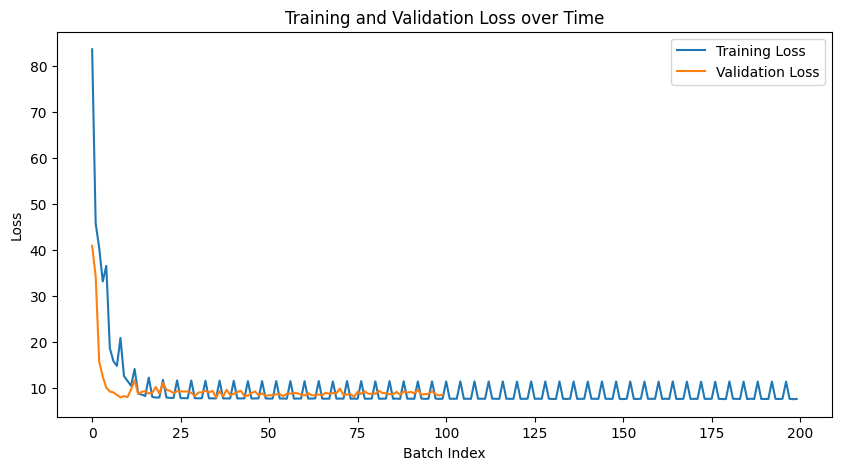

In [28]:
## logarithmic loss plot
#train_loss_log = [loss for loss in train_loss]
#validate_loss_log = [loss for loss in validate_loss]
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(lossi, label='Training Loss')
plt.plot(val_lossi, label='Validation Loss')
plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Time')
plt.legend()
plt.show()

In [ ]:
## how do i smooth the loss curve?
def smooth_loss(losses, window_size=100):
    smoothed = []
    for i in range(len(losses)):
        if i < window_size:
            smoothed.append(losses[i])
        else:
            window_avg = sum(losses[i-window_size:i]) / window_size
            smoothed.append(window_avg)
    return smoothed

smoothed_train_loss = smooth_loss(train_loss, window_size=100)
smoothed_val_loss = smooth_loss(validate_loss, window_size=100)

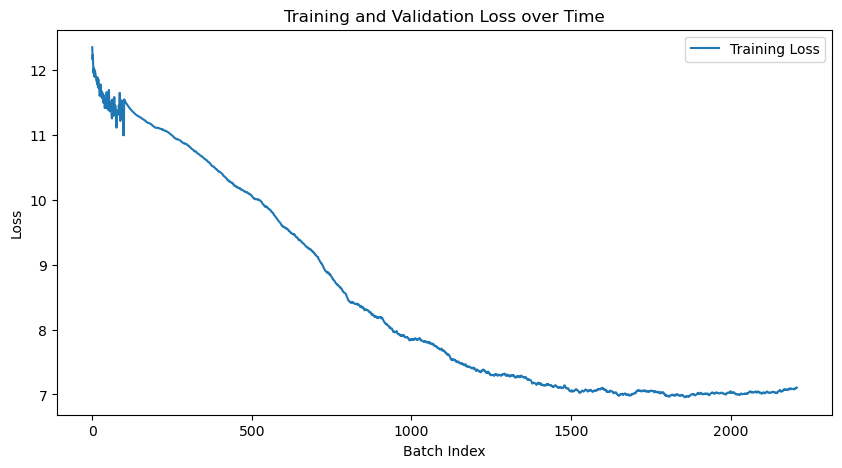

In [ ]:
##plotting the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(smoothed_train_loss, label='Training Loss')
#plt.plot(smoothed_val_loss, label='Validation Loss')
plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Time')
plt.legend()
plt.show()

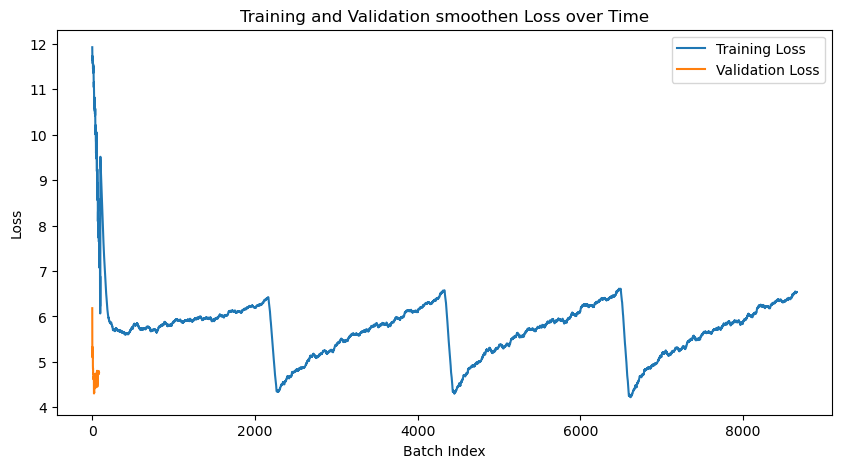

In [ ]:
##plotting the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(loss_smooth, label='Training Loss')
plt.plot(val_lossi, label='Validation Loss')
plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.title('Training and Validation smoothen Loss over Time')
plt.legend()
plt.show()

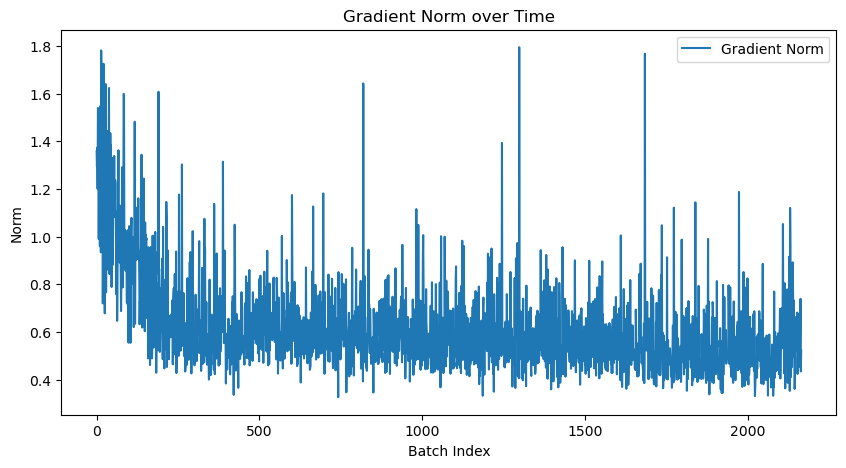

In [ ]:
## plotting the norm of the gradients
plt.figure(figsize=(10,5))
plt.plot(total_norm, label='Gradient Norm')
plt.xlabel('Batch Index')
plt.ylabel('Norm')
plt.title('Gradient Norm over Time')
plt.legend()
plt.show()

In [ ]:
# smoothing the gradient norm curve
norm_smooth = []
window_size = 100
for i in range(len(total_norm)):
    if i < window_size:
        norm_smooth.append(total_norm[i])
    else:
        window_avg = sum(total_norm[i-window_size:i]) / window_size
        norm_smooth.append(window_avg)

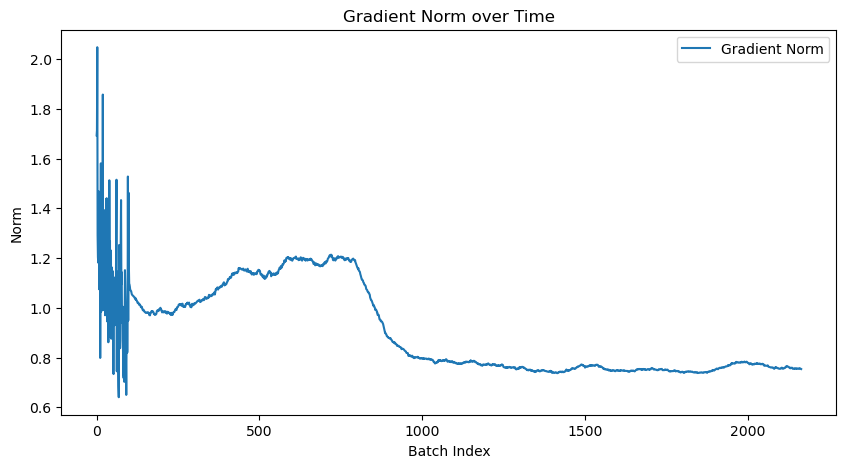

In [ ]:
## plotting the norm of the gradients
plt.figure(figsize=(10,5))
plt.plot(norm_smooth, label='Gradient Norm')
plt.xlabel('Batch Index')
plt.ylabel('Norm')
plt.title('Gradient Norm over Time')
plt.legend()
plt.show()

In [ ]:

|   _orig_mod.decoder_blocks.4.msk_attn.dec_heads.0.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.0.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.0.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.4.msk_attn.dec_heads.1.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.1.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.1.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.4.msk_attn.dec_heads.2.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.2.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.2.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.4.msk_attn.dec_heads.3.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.3.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.3.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.4.msk_attn.dec_heads.4.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.4.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.4.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.4.msk_attn.dec_heads.5.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.5.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.5.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.4.msk_attn.dec_heads.6.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.6.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.6.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.4.msk_attn.dec_heads.7.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.7.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.4.msk_attn.dec_heads.7.value.weight  |   32,768   |
|        _orig_mod.decoder_blocks.4.msk_attn.proj.weight         |  262,144   |
|         _orig_mod.decoder_blocks.4.msk_attn.proj.bias          |    512     |
|  _orig_mod.decoder_blocks.4.cross_attn.enc_heads.0.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.0.query.weight |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.0.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.4.cross_attn.enc_heads.1.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.1.query.weight |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.1.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.4.cross_attn.enc_heads.2.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.2.query.weight |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.2.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.4.cross_attn.enc_heads.3.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.3.query.weight |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.3.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.4.cross_attn.enc_heads.4.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.4.query.weight |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.4.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.4.cross_attn.enc_heads.5.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.5.query.weight |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.5.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.4.cross_attn.enc_heads.6.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.6.query.weight |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.6.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.4.cross_attn.enc_heads.7.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.7.query.weight |   32,768   |
| _orig_mod.decoder_blocks.4.cross_attn.enc_heads.7.value.weight |   32,768   |
|       _orig_mod.decoder_blocks.4.cross_attn.proj.weight        |  262,144   |
|        _orig_mod.decoder_blocks.4.cross_attn.proj.bias         |    512     |
|          _orig_mod.decoder_blocks.4.ffwd.net.0.weight          | 1,048,576  |
|           _orig_mod.decoder_blocks.4.ffwd.net.0.bias           |   2,048    |
|          _orig_mod.decoder_blocks.4.ffwd.net.2.weight          | 1,048,576  |
|           _orig_mod.decoder_blocks.4.ffwd.net.2.bias           |    512     |
|             _orig_mod.decoder_blocks.4.ln1.weight              |    512     |
|              _orig_mod.decoder_blocks.4.ln1.bias               |    512     |
|             _orig_mod.decoder_blocks.4.ln2.weight              |    512     |
|              _orig_mod.decoder_blocks.4.ln2.bias               |    512     |
|             _orig_mod.decoder_blocks.4.ln3.weight              |    512     |
|              _orig_mod.decoder_blocks.4.ln3.bias               |    512     |
|   _orig_mod.decoder_blocks.5.msk_attn.dec_heads.0.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.0.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.0.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.5.msk_attn.dec_heads.1.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.1.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.1.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.5.msk_attn.dec_heads.2.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.2.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.2.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.5.msk_attn.dec_heads.3.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.3.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.3.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.5.msk_attn.dec_heads.4.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.4.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.4.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.5.msk_attn.dec_heads.5.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.5.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.5.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.5.msk_attn.dec_heads.6.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.6.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.6.value.weight  |   32,768   |
|   _orig_mod.decoder_blocks.5.msk_attn.dec_heads.7.key.weight   |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.7.query.weight  |   32,768   |
|  _orig_mod.decoder_blocks.5.msk_attn.dec_heads.7.value.weight  |   32,768   |
|        _orig_mod.decoder_blocks.5.msk_attn.proj.weight         |  262,144   |
|         _orig_mod.decoder_blocks.5.msk_attn.proj.bias          |    512     |
|  _orig_mod.decoder_blocks.5.cross_attn.enc_heads.0.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.0.query.weight |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.0.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.5.cross_attn.enc_heads.1.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.1.query.weight |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.1.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.5.cross_attn.enc_heads.2.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.2.query.weight |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.2.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.5.cross_attn.enc_heads.3.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.3.query.weight |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.3.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.5.cross_attn.enc_heads.4.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.4.query.weight |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.4.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.5.cross_attn.enc_heads.5.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.5.query.weight |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.5.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.5.cross_attn.enc_heads.6.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.6.query.weight |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.6.value.weight |   32,768   |
|  _orig_mod.decoder_blocks.5.cross_attn.enc_heads.7.key.weight  |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.7.query.weight |   32,768   |
| _orig_mod.decoder_blocks.5.cross_attn.enc_heads.7.value.weight |   32,768   |
|       _orig_mod.decoder_blocks.5.cross_attn.proj.weight        |  262,144   |
|        _orig_mod.decoder_blocks.5.cross_attn.proj.bias         |    512     |
|          _orig_mod.decoder_blocks.5.ffwd.net.0.weight          | 1,048,576  |
|           _orig_mod.decoder_blocks.5.ffwd.net.0.bias           |   2,048    |
|          _orig_mod.decoder_blocks.5.ffwd.net.2.weight          | 1,048,576  |
|           _orig_mod.decoder_blocks.5.ffwd.net.2.bias           |    512     |
|             _orig_mod.decoder_blocks.5.ln1.weight              |    512     |
|              _orig_mod.decoder_blocks.5.ln1.bias               |    512     |
|             _orig_mod.decoder_blocks.5.ln2.weight              |    512     |
|              _orig_mod.decoder_blocks.5.ln2.bias               |    512     |
|             _orig_mod.decoder_blocks.5.ln3.weight              |    512     |
|              _orig_mod.decoder_blocks.5.ln3.bias               |    512     |
|                    _orig_mod.lm_head.weight                    | 61,208,064 |
|                     _orig_mod.lm_head.bias                     |  119,547   |
+----------------------------------------------------------------+------------+
Total Trainable Params: 227,985,659